##ECE M214A Project: Speaker Region Identification



Zilai WANG 
Spec_Augmentation Application



## 2. Getting familiar with the data

In [20]:
from glob import glob
from tqdm import tqdm
import numpy as np
import librosa
import torchaudio
import random
from scipy.interpolate import interp1d


## 3. Feature Extraction

We first define a pair of functions to create features and labels for our classification model:


In [21]:

def time_warp(spec, W):
    num_rows, num_cols = spec.shape # 128 * variable
    #print("spectrogram shape is: ",num_rows,' ',num_cols)

    pt_time = np.random.randint(W, num_cols - W)
    pt_shift = np.random.randint(-W, W)

    src_path = np.linspace(0, num_cols - 1, num_cols)
    dst_path = np.copy(src_path)
    dst_path[pt_time:] += pt_shift 

    interp_func = interp1d(dst_path, src_path, bounds_error=False, fill_value="extrapolate") # linear map from dst_path to src_path
    new_col_indices = interp_func(np.arange(num_cols))
    
    warped_spec = np.zeros_like(spec)
    for i in range(num_rows):
        warped_spec[i, :] = np.interp(np.arange(num_cols), new_col_indices, spec[i, :], left=0, right=0)

    return warped_spec

def spec_augment(mel_spectrogram, frequency_masking_para, time_masking_para, frequency_mask_num, time_mask_num):
    v, tau = mel_spectrogram.shape
    mel_spectrogram = time_warp(mel_spectrogram, W=20)  # Suggested W value for time warping = 20
    
    # Frequency masking
    for _ in range(frequency_mask_num):
        f = np.random.uniform(low=0.0, high=frequency_masking_para)
        f0 = random.randint(0, v - int(f))
        mel_spectrogram[f0:f0 + int(f), :] = 0

    # Time masking
    for _ in range(time_mask_num):
        t = np.random.uniform(low=0.0, high=time_masking_para)
        t0 = random.randint(0, tau - int(t))
        mel_spectrogram[:, t0:t0 + int(t)] = 0

    return mel_spectrogram

def extract_feature(audio_file, n_mfcc=13, resample=False, augment=True,spectral_subtraction_enabled=False):
    audio, fs = torchaudio.load(audio_file)
    audio = audio.numpy().reshape(-1)

    if resample:
        audio = librosa.resample(audio, orig_sr=fs, target_sr=16000)
        fs = 16000

    S = librosa.feature.melspectrogram(y=audio, sr=fs, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)

    # if spectral_subtraction_enabled:
    #     # Apply spectral subtraction
    #     log_S = spectral_subtraction(log_S)


    features_original = librosa.feature.mfcc(S=log_S, sr=fs, n_mfcc=n_mfcc)
    #print(features_original.shape)
    feat_out_original = np.mean(features_original, axis=1)

    if augment :
        augmented_log_S = spec_augment(log_S, frequency_masking_para=15, time_masking_para=20, frequency_mask_num=1, time_mask_num=1)
        #augmented_log_S = spec_augment(log_S, frequency_masking_para=5, time_masking_para=10, frequency_mask_num=1, time_mask_num=1)

        #augmented_audio = librosa.feature.inverse.mel_to_audio(augmented_log_S, sr=fs, n_fft=2048, hop_length=512)


        features_augmented = librosa.feature.mfcc(S=augmented_log_S, sr=fs, n_mfcc=n_mfcc)
        feat_out_augmented = np.mean(features_augmented, axis=1)
        return feat_out_original, feat_out_augmented
        #return feat_out_augmented
    else:
        return feat_out_original





In [22]:

def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
    # global ROC
    # ROC = ROC+1
  elif 'LES' in file_name:
    label=1
    # global LES
    # LES = LES+1
  elif 'DC' in file_name:
    label=2
    # global DC
    # DC = DC+1
  elif 'PRV' in file_name:
    label=3
    # global PRV
    # PRV = PRV+1
  elif 'VLD' in file_name:
    label=4
    # global VLD
    # VLD = VLD+1
  else:
    raise ValueError('invalid file name')
  return label

In [23]:

# #First we obtain the list of all files in the train_clean directory
# train_files = glob('/Users/zilaiwang/Documents/214-proj/W24_ECE_M214A_Project/project_data/train_clean/*.wav')

# #Let's sort it so that we're all using the same file list order
# #and you can continue processing the features from a given file if it stops
# #partway through running
# train_files.sort()

# train_feat=[]
# train_label=[]

# for wav in tqdm(train_files):

#   train_feat.append(extract_feature(wav,augment = False))
#   train_label.append(get_label(wav))

Let us now call these functions to extract the features and labels from the train_clean directory

In [24]:

#First we obtain the list of all files in the train_clean directory
train_files = glob('/Users/zilaiwang/Documents/214-proj/W24_ECE_M214A_Project/project_data/train_clean/*.wav')


train_files.sort()

train_feat=[]
train_label=[]



n_augmentations = 1  # Number of additional augmentations to append
for wav in tqdm(train_files):
  label = get_label(wav)
  original_feat, augmented_feat = extract_feature(wav)

  train_feat.append(original_feat)
  train_label.append(label)
  if augmented_feat is not None and (label==1):# 1 for LES
      train_label.append(label) 
      train_feat.append(augmented_feat)

       # Append additional augmentations if required
      # for _ in range(n_augmentations):
      #       __, additional_augmented_feat = extract_feature(wav, augment=True)
      #       train_feat.append(additional_augmented_feat)
      #       train_label.append(label)
  # elif augmented_feat is not None and (label==4):
  #     train_label.append(label) 
  #     train_feat.append(augmented_feat)

print("Len of train feat: ",len(train_feat))
print("len of train label: ",len(train_label))



  0%|          | 0/4372 [00:00<?, ?it/s]

100%|██████████| 4372/4372 [04:47<00:00, 15.20it/s]

Len of train feat:  4831
len of train label:  4831


ROC = 647  0
LES = 459  1
DCB = 2457 2
PRV = 242  3
VLD = 567  4

In [25]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob('/Users/zilaiwang/Documents/214-proj/W24_ECE_M214A_Project/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_feat=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat.append(extract_feature(wav,augment = False))
  #print(np.asarray(test_clean_feat).shape)
  test_clean_label.append(get_label(wav))
print(np.asarray(test_clean_feat).shape)

  0%|          | 0/447 [00:00<?, ?it/s]

100%|██████████| 447/447 [00:23<00:00, 18.63it/s]

(447, 13)


In [26]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob('/Users/zilaiwang/Documents/214-proj/W24_ECE_M214A_Project/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_feat=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):

  test_noisy_feat.append(extract_feature(wav,augment = False))
  test_noisy_label.append(get_label(wav))

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:22<00:00, 15.62it/s]


## 4. Model Training and Predictions

Now we'll train the backend system to predict the regions from the input features.  We'll use an xgboosted decision tree for this.  An advantage of this model is that we can also parse the decision tree and measure the impact of different features in the end result for explainability

In [27]:
#Install shap library
#!pip install shap

In [28]:
import xgboost
import numpy as np
import shap
import pandas as pd

#Format input data

#Edit this variable to create a list that contains your feature names
feat_names=['specaugment' +str(n) for n in range(len(train_feat[0]))]

train_feat_df = pd.DataFrame(data=np.stack(train_feat), columns=feat_names)
y_train=np.stack(train_label)



test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat), columns=feat_names)
y_test_clean=np.stack(test_clean_label)


test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat), columns=feat_names)
y_test_noisy=np.stack(test_noisy_label)

model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))


Train Clean Acc = 1.0
Test Clean Acc = 0.7472035794183445
Test Noisy Acc = 0.8242074927953891


To save a dataframe of features, uncomment and run the following block of code

In [29]:
train_feat_df.to_csv('/Users/zilaiwang/Documents/214-proj/feature/specaugment_train.csv' )
test_clean_feat_df.to_csv('/Users/zilaiwang/Documents/214-proj/feature/specaugment_test_clean.csv')
test_noisy_feat_df.to_csv('/Users/zilaiwang/Documents/214-proj/feature/specaugment_test_noise.csv')

In [30]:
train_feat_df = pd.read_csv('/Users/zilaiwang/Documents/214-proj/feature/specaugment_train.csv', index_col = 0)
test_clean_feat_df = pd.read_csv('/Users/zilaiwang/Documents/214-proj/feature/specaugment_test_clean.csv', index_col = 0)
test_noisy_feat_df = pd.read_csv('/Users/zilaiwang/Documents/214-proj/feature/specaugment_test_noise.csv', index_col = 0)

In [31]:
feat_names=['specaugment_' +str(n) for n in range(len(train_feat[0]))]





model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))


Train Clean Acc = 1.0
Test Clean Acc = 0.7472035794183445
Test Noisy Acc = 0.8242074927953891


To Load a preexisting dataframe of features (saved from a previous notebook), run the following cell and then train the model

## 5. Interpreting Results and Explainability

To see the impact different features have on the model, we create a plot of the feature importances. The features are listed top to bottom in order of how important they were to the decision.

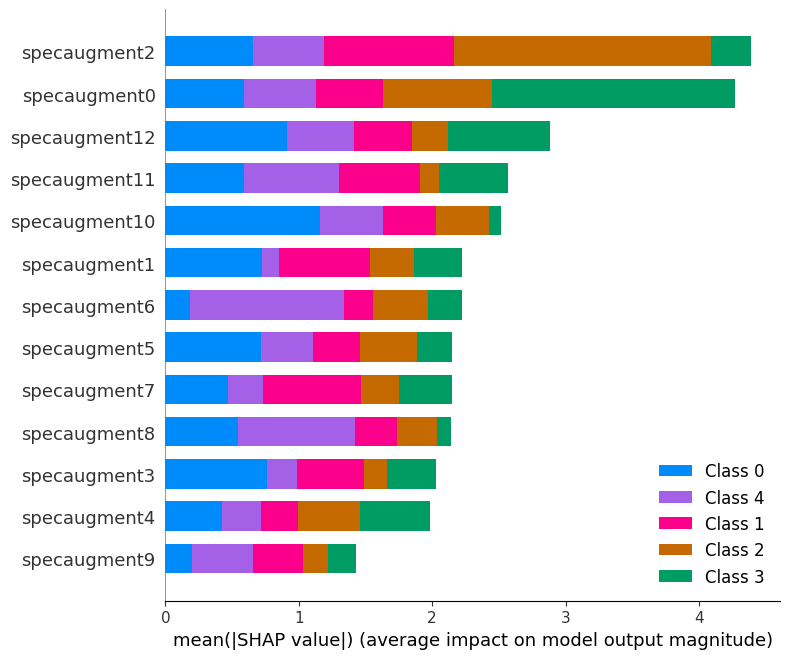

In [32]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_feat_df)
shap.summary_plot(shap_values, train_feat_df)

And we can see a confusion matrix of the mispredictions

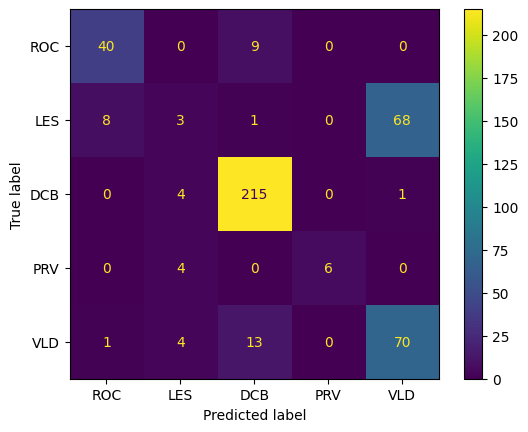

In [33]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

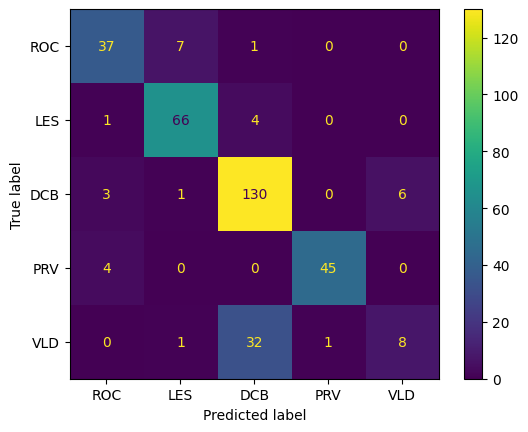

In [34]:

confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()